In [127]:
# import relevant libraries

import pandas as pd
from sklearn.metrics import classification_report

In [128]:
# load data into dataframe

df_2024 = pd.read_csv("/content/combined_data_nocovid_adjustedyears.csv")

In [129]:
print(df_2024.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 497872 entries, 0 to 497871
Data columns (total 16 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   YEAR             497872 non-null  int64  
 1   MONTH            497872 non-null  int64  
 2   DAY              497872 non-null  int64  
 3   HOUR             497872 non-null  int64  
 4   MINUTE           497872 non-null  int64  
 5   SHIFT            497872 non-null  object 
 6   METHOD           497872 non-null  object 
 7   OFFENSE          497872 non-null  object 
 8   BLOCK            497872 non-null  object 
 9   WARD             497872 non-null  int64  
 10  ANC              497872 non-null  object 
 11  DISTRICT         497872 non-null  int64  
 12  PSA              497872 non-null  int64  
 13  VOTING_PRECINCT  497872 non-null  object 
 14  LATITUDE         497872 non-null  float64
 15  LONGITUDE        497872 non-null  float64
dtypes: float64(2), int64(8), object(6)
mem

In [130]:
# Drop rows where offense is "ARSON"
df_2024 = df_2024[df_2024["OFFENSE"] != "ARSON"]

In [131]:
df_2024["OFFENSE"].unique()

array(['THEFT', 'ASSAULT W/DANGEROUS WEAPON', 'ROBBERY',
       'MOTOR VEHICLE THEFT', 'BURGLARY', 'HOMICIDE', 'SEX ABUSE'],
      dtype=object)

In [132]:
df_2024["OFFENSE"] = df_2024["OFFENSE"].replace({"ROBBERY": "THEFT", "BURGLARY": "THEFT"})
df_2024["OFFENSE"] = df_2024["OFFENSE"].replace({"MOTOR VEHICLE THEFT" : "THEFT"})
df_2024["OFFENSE"].unique()

array(['THEFT', 'ASSAULT W/DANGEROUS WEAPON', 'HOMICIDE', 'SEX ABUSE'],
      dtype=object)

In [133]:
df_2024["OFFENSE"].value_counts()

,count
OFFENSE,
THEFT,461367
ASSAULT W/DANGEROUS WEAPON,30527
SEX ABUSE,3417
HOMICIDE,2200


In [134]:
df_2024["OFFENSE"] = df_2024["OFFENSE"].replace({"HOMICIDE": "VIOLENT CRIME"})
df_2024["OFFENSE"] = df_2024["OFFENSE"].replace({"SEX ABUSE": "VIOLENT CRIME"})
df_2024["OFFENSE"] = df_2024["OFFENSE"].replace({"ASSAULT W/DANGEROUS WEAPON" : "VIOLENT CRIME"})

df_2024["OFFENSE"].unique()

array(['THEFT', 'VIOLENT CRIME'], dtype=object)

In [135]:
df_2024["OFFENSE"].value_counts()

,count
OFFENSE,
THEFT,461367
VIOLENT CRIME,36144


In [136]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Define X (features) and y (target)
x_independent = df_2024.drop(columns=['OFFENSE', "METHOD"])  # Drop the target variable
y_dependent = df_2024['OFFENSE']  # Target variable

# Label encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_dependent)

# Define categorical and numerical columns
categorical_cols = ['SHIFT', 'ANC', 'VOTING_PRECINCT', "BLOCK"]  # Categorical features
numerical_cols = ['YEAR', 'MONTH', 'DAY', 'HOUR', 'MINUTE', 'WARD', 'DISTRICT', 'PSA', 'LATITUDE', 'LONGITUDE']  # Numerical features

# Label encode categorical variables
for col in categorical_cols:
    le = LabelEncoder()
    x_independent[col] = le.fit_transform(x_independent[col])

# Split the data: 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(x_independent, y_encoded, test_size=0.20, random_state=42)

# Print shapes of the training and test sets
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")

X_train shape: (398008, 14), X_test shape: (99503, 14)
y_train shape: (398008,), y_test shape: (99503,)


In [137]:
print(label_encoder.classes_)

['THEFT' 'VIOLENT CRIME']


In [138]:
from imblearn.under_sampling import RandomUnderSampler

# 'THEFT' is the majority class (label 0) that needs to undersample

# Create a RandomUnderSampler object
rus = RandomUnderSampler(random_state=42, sampling_strategy={0: 40000})

# Resample the training data
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

# Now, X_train_resampled and y_train_resampled contain the undersampled data

In [139]:
from imblearn.over_sampling import SMOTE
sampling_strategy = {1: 36144}  # Specify the label and desired number of samples

smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)

# Apply SMOTE
X_resampled, y_resampled = smote.fit_resample(X_train_resampled, y_train_resampled)

In [140]:
# Check the new class distribution
print(f"Original class distribution:\n{y_train.shape}")
print(f"Resampled class distribution:\n{y_resampled.shape}")

Original class distribution:
(398008,)
Resampled class distribution:
(76144,)


In [155]:
from xgboost import XGBClassifier

# Create and configure the XGBoost model
model_xgb = XGBClassifier(
    eval_metric='mlogloss',         # Set evaluation metric for multi-class classification
    random_state=42,
    n_estimators=500,
    learning_rate=0.05,
    max_depth=7,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=None,
    tree_method='hist'
)
# Fit the model
model_xgb.fit(X_resampled, y_resampled, verbose=True)

# Make predictions
y_pred = model_xgb.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.74      0.84     92354
           1       0.17      0.68      0.27      7149

    accuracy                           0.74     99503
   macro avg       0.57      0.71      0.56     99503
weighted avg       0.91      0.74      0.80     99503



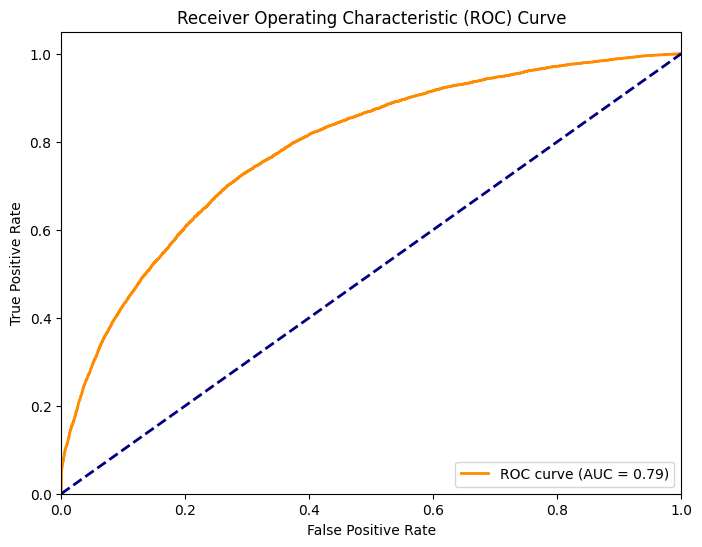

In [156]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

y_pred_prob = model_xgb.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:, 1])

# Calculate AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [157]:
from sklearn.linear_model import LogisticRegression

model_lr = LogisticRegression(max_iter=2000, random_state=42)
# Fit the model
model_lr.fit(X_resampled, y_resampled)

# Make predictions
y_pred = model_lr.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.96      0.71      0.82     92354
           1       0.15      0.64      0.24      7149

    accuracy                           0.71     99503
   macro avg       0.55      0.68      0.53     99503
weighted avg       0.90      0.71      0.78     99503



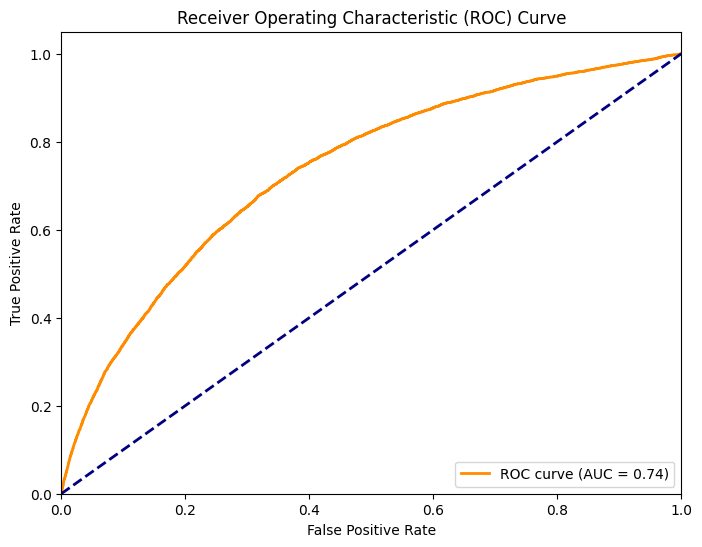

In [158]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

y_pred_prob = model_lr.predict_proba(X_test)

# Assuming a binary classification problem (adjust if multi-class)
# For multi-class, you'll need to loop through each class and plot ROC curves
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:, 1])

# Calculate AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [159]:
import lightgbm as lgb

model_lgb = lgb.LGBMClassifier()
# Fit the model
model_lgb.fit(X_resampled, y_resampled)

# Make predictions
y_pred = model_lgb.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

[LightGBM] [Info] Number of positive: 36144, number of negative: 40000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006539 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1192
[LightGBM] [Info] Number of data points in the train set: 76144, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.474680 -> initscore=-0.101368
[LightGBM] [Info] Start training from score -0.101368
              precision    recall  f1-score   support

           0       0.97      0.73      0.83     92354
           1       0.16      0.68      0.26      7149

    accuracy                           0.73     99503
   macro avg       0.57      0.71      0.55     99503
weighted avg       0.91      0.73      0.79     99503



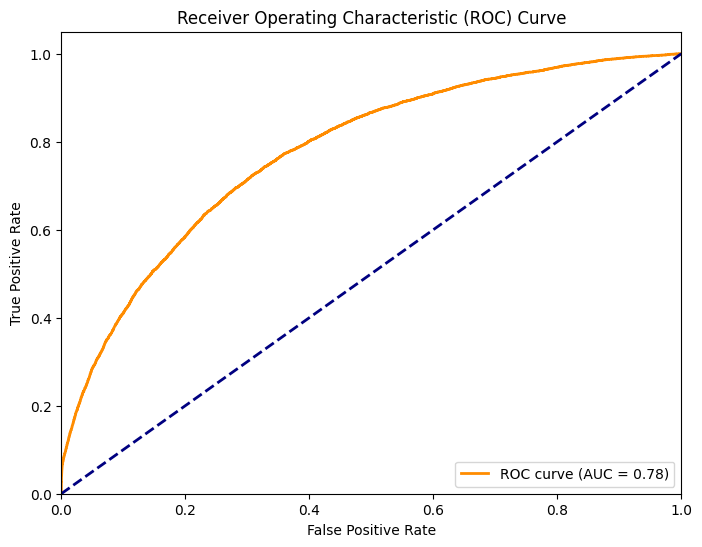

In [160]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

y_pred_prob = model_lgb.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:, 1])

# Calculate AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [161]:
from catboost import CatBoostClassifier

model_cbc = CatBoostClassifier(silent=True, random_state=42)
# Fit the model
model_cbc.fit(X_resampled, y_resampled)

# Make predictions
y_pred = model_cbc.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.74      0.84     92354
           1       0.17      0.68      0.27      7149

    accuracy                           0.74     99503
   macro avg       0.57      0.71      0.55     99503
weighted avg       0.91      0.74      0.80     99503



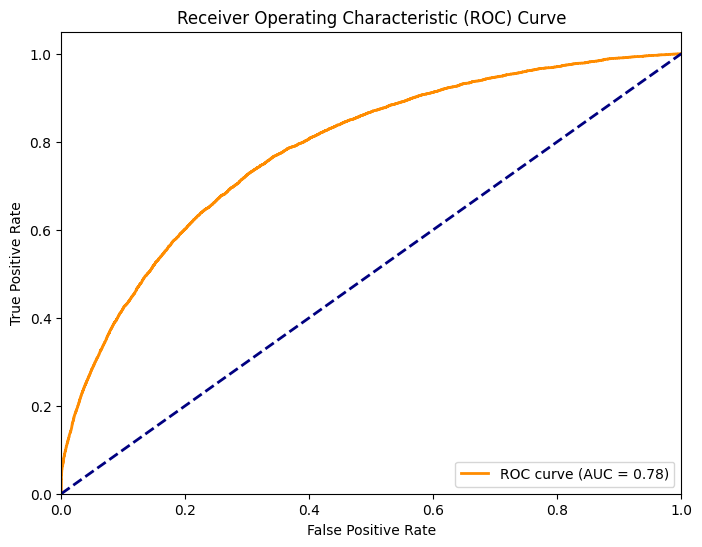

In [148]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

y_pred_prob = model_cbc.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:, 1])

# Calculate AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [149]:
from sklearn.neighbors import KNeighborsClassifier

model_knn = KNeighborsClassifier()
# Fit the model
model_knn.fit(X_resampled, y_resampled)

# Make predictions
y_pred = model_knn.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.66      0.78     92354
           1       0.13      0.63      0.21      7149

    accuracy                           0.66     99503
   macro avg       0.54      0.65      0.50     99503
weighted avg       0.90      0.66      0.74     99503



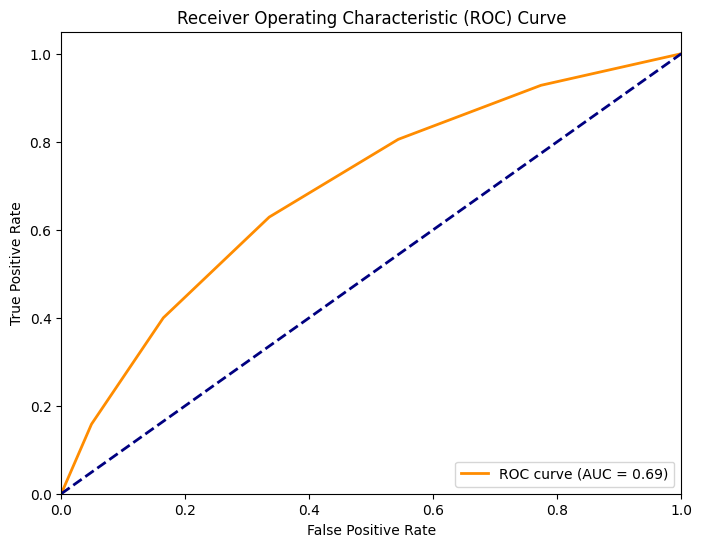

In [150]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

y_pred_prob = model_knn.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:, 1])

# Calculate AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [151]:
from sklearn.naive_bayes import GaussianNB

model_naivebayes = GaussianNB()
# Fit the model
model_naivebayes.fit(X_resampled, y_resampled)

# Make predictions
y_pred = model_naivebayes.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.70      0.81     92354
           1       0.14      0.63      0.23      7149

    accuracy                           0.70     99503
   macro avg       0.55      0.66      0.52     99503
weighted avg       0.90      0.70      0.77     99503



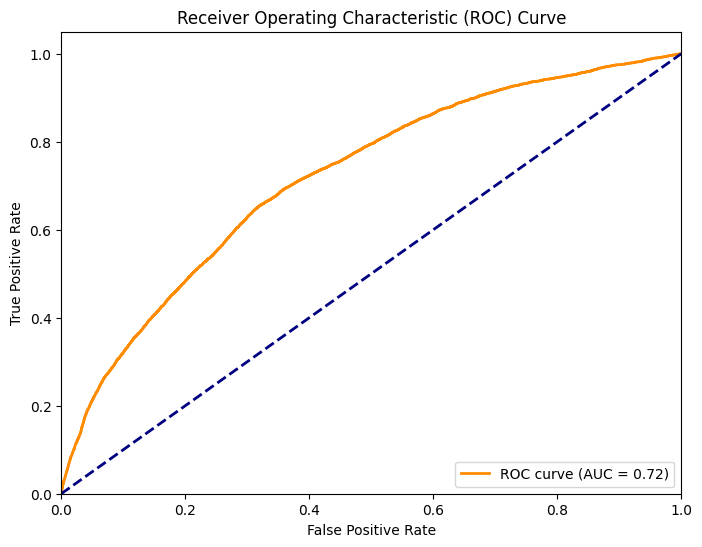

In [152]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

y_pred_prob = model_naivebayes.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:, 1])

# Calculate AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [153]:
from sklearn.ensemble import RandomForestClassifier

model_randomforest = RandomForestClassifier(random_state=42)
# Fit the model
model_randomforest.fit(X_resampled, y_resampled)

# Make predictions
y_pred = model_randomforest.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.75      0.84     92354
           1       0.17      0.66      0.27      7149

    accuracy                           0.74     99503
   macro avg       0.57      0.71      0.56     99503
weighted avg       0.91      0.74      0.80     99503



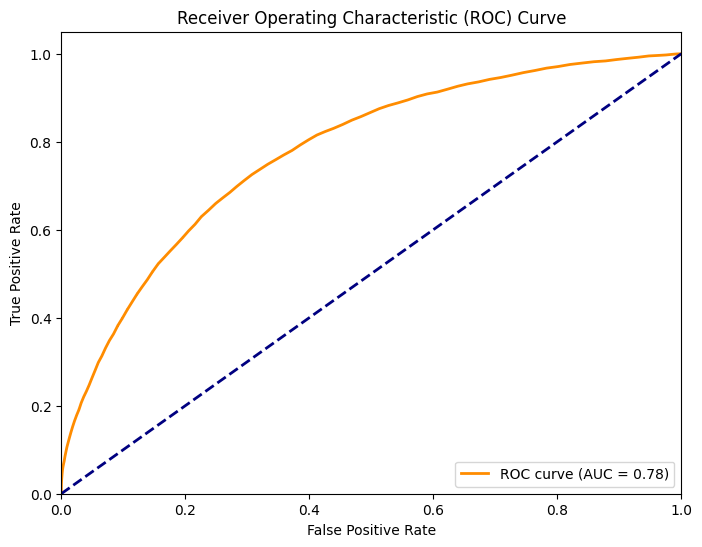

In [154]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

y_pred_prob = model_randomforest.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:, 1])

# Calculate AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()